In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')

In [3]:
# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures))

all targeted structures: [u'VISal', u'VISl', u'VISp', u'VISpm']


In [49]:
# Download experiment containers for VISp experiments
visp_ecs = boc.get_experiment_containers(targeted_structures=['VISp'])
print("all VISp experiment containers: %d" % len(visp_ecs))

all VISp experiment containers: 25


In [4]:
# Download a list of all imaging depths
depths = boc.get_all_imaging_depths()
print("all imaging depths: " + str(depths))

all imaging depths: [175, 275, 350, 375]


In [5]:
# Download a list of all stimuli
stims = boc.get_all_stimuli()
print("all stimuli:\n")
pprint.pprint(stims)

all stimuli:

['drifting_gratings',
 'locally_sparse_noise',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']


In [6]:
# Download a list of all cre driver lines 
cre_lines = boc.get_all_cre_lines()
print("all cre lines: " + str(cre_lines))

all cre lines: [u'Cux2-CreERT2', u'Rbp4-Cre', u'Rorb-IRES2-Cre', u'Scnn1a-Tg3-Cre']


In [14]:
import allensdk.brain_observatory.stimulus_info as stim_info

# Find the experiment with VISp, Cux2-CreERT2, 175, drifting gratings stimulus
crel = 'Cux2-CreERT2';
ts = 'VISp';
imdepth = 175;
exp = boc.get_ophys_experiments(cre_lines=[crel], 
                                stimuli=[stim_info.DRIFTING_GRATINGS],
                                targeted_structures=[ts],
                                imaging_depths=[imdepth])#[0]
print("Experiment with static gratings:")
pprint.pprint(exp)

Experiment with static gratings:
[{'age_days': 156.0,
  'cre_line': u'Cux2-CreERT2',
  'experiment_container_id': 511507650,
  'id': 501794235,
  'imaging_depth': 175,
  'session_type': u'three_session_B',
  'targeted_structure': u'VISp'},
 {'age_days': 113.0,
  'cre_line': u'Cux2-CreERT2',
  'experiment_container_id': 511510855,
  'id': 510705057,
  'imaging_depth': 175,
  'session_type': u'three_session_B',
  'targeted_structure': u'VISp'},
 {'age_days': 143.0,
  'cre_line': u'Cux2-CreERT2',
  'experiment_container_id': 511510650,
  'id': 501886692,
  'imaging_depth': 175,
  'session_type': u'three_session_B',
  'targeted_structure': u'VISp'},
 {'age_days': 99.0,
  'cre_line': u'Cux2-CreERT2',
  'experiment_container_id': 511510718,
  'id': 510345479,
  'imaging_depth': 175,
  'session_type': u'three_session_B',
  'targeted_structure': u'VISp'},
 {'age_days': 144.0,
  'cre_line': u'Cux2-CreERT2',
  'experiment_container_id': 511509529,
  'id': 500964514,
  'imaging_depth': 175,
  'se

## Find cell data

In [50]:
import pandas as pd

# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("total cells: %d" % len(cells))
# find direction selective cells in VISp
visp_ec_ids = [ ec['id'] for ec in visp_ecs ]
visp_cells = cells[cells['experiment_container_id'].isin(visp_ec_ids)]
print("VISp cells: %d" % len(visp_cells))

# significant response to drifting gratings stimulus
sig_cells = visp_cells[visp_cells['p_dg'] < 0.05]
print("cells with sig. response to drifting gratings: %d" % len(sig_cells))

# direction selective cells
dsi_cells = sig_cells[(sig_cells['dsi_dg'] > 0.5) & (sig_cells['dsi_dg'] < 1.5)]
print("direction-selective cells: %d" % len(dsi_cells))

total cells: 18260
VISp cells: 7167
cells with sig. response to drifting gratings: 4179
direction-selective cells: 2257


## Find experiments for cells

In [51]:
import allensdk.brain_observatory.stimulus_info as stim_info

# find experiment containers for those cells
dsi_ec_ids = dsi_cells['experiment_container_id'].unique()
print("total dsi experiment containers: %d" % len(dsi_ec_ids))

# Download the ophys experiments containing the drifting gratings stimulus for VISp experiment containers
dsi_exps = boc.get_ophys_experiments(experiment_container_ids=dsi_ec_ids, stimuli=[stim_info.DRIFTING_GRATINGS])
print("VISp drifting gratings ophys experiments: %d" % len(dsi_exps))

print("Example ophys experiment:")
pprint.pprint(dsi_exps[0])

total dsi experiment containers: 25
VISp drifting gratings ophys experiments: 25
Example ophys experiment:
{'age_days': 123.0,
 'cre_line': u'Rorb-IRES2-Cre',
 'experiment_container_id': 511507144,
 'id': 501724959,
 'imaging_depth': 275,
 'session_type': u'three_session_A',
 'targeted_structure': u'VISp'}


In [52]:
# pick a direction-selective cell and find its NWB file
dsi_cell = dsi_cells.iloc[0]

# figure out which ophys experiment has the drifting gratings stimulus for the cell's experiment container
cell_exp = boc.get_ophys_experiments(experiment_container_ids=[dsi_cell['experiment_container_id']], 
                                     stimuli=[stim_info.DRIFTING_GRATINGS])[0]

data_set = boc.get_ophys_experiment_data(cell_exp['id'])

print("Metadata from NWB file:")
pprint.pprint(data_set.get_metadata())

print("stimuli available in this file:")
print(data_set.list_stimuli())

Metadata from NWB file:
{'age_days': 93,
 'cre_line': 'Scnn1a-Tg3-Cre',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'excitation_lambda': '910 microns',
 'experiment_container_id': 511498742,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Scnn1a-Tg3-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)',
 'imaging_depth_um': 350,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 511534603,
 'session_start_time': datetime.datetime(2016, 4, 1, 9, 12, 3),
 'session_type': 'three_session_A',
 'sex': 'male',
 'targeted_structure': 'VISp'}
stimuli available in this file:
[u'drifting_gratings', u'natural_movie_one', u'natural_movie_three', u'spontaneous']


## Fluorescence traces

In [53]:
dsi_cell_id = dsi_cell['cell_specimen_id']
time, raw_traces = data_set.get_fluorescence_traces(cell_specimen_ids=[dsi_cell_id])
_, neuropil_traces = data_set.get_neuropil_traces(cell_specimen_ids=[dsi_cell_id])
_, corrected_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[dsi_cell_id])
_, dff_traces = data_set.get_dff_traces(cell_specimen_ids=[dsi_cell_id])

In [56]:
from allensdk.brain_observatory.r_neuropil import estimate_contamination_ratios

data_set = boc.get_ophys_experiment_data(510221121)
csid = data_set.get_cell_specimen_ids()[0]

# get trace
time, raw_traces = data_set.get_fluorescence_traces(cell_specimen_ids=[csid])
_, neuropil_traces = data_set.get_neuropil_traces(cell_specimen_ids=[csid])

r = 0.394000
max error = 0.002809


In [62]:
# neuropil correction
results = estimate_contamination_ratios(raw_traces[0], neuropil_traces[0])
correction = raw_traces[0] - results['r'] * neuropil_traces[0]
print("r = %f" % results['r'])
print("max error = %f" % results['err'])

_, corrected_traces = data_set.get_corrected_fluorescence_traces(cell_specimen_ids=[csid])

r = 0.394000
max error = 0.002809


In [64]:
import numpy as np

# compute df/f
from allensdk.brain_observatory.dff import compute_dff
dff = compute_dff(np.array(corrected_traces))


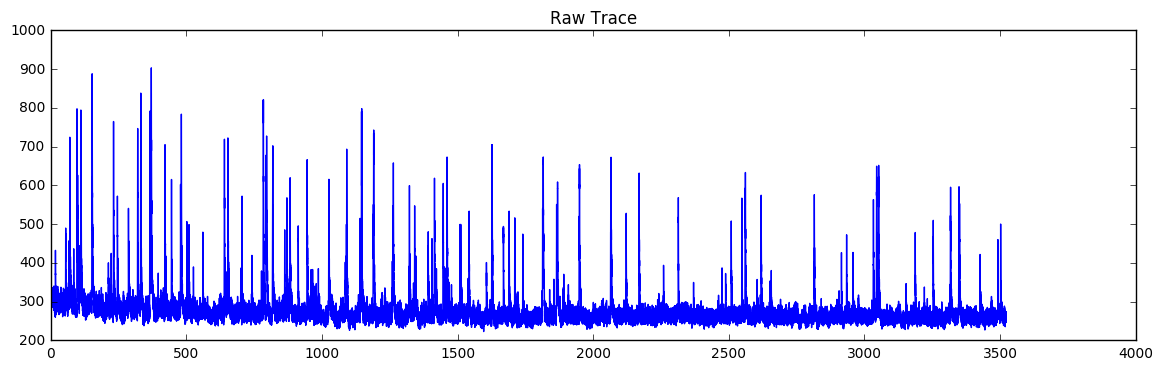

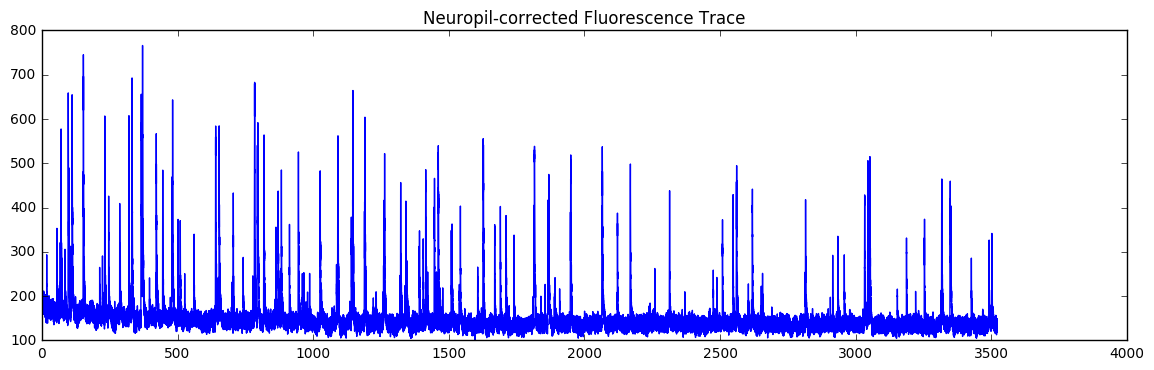

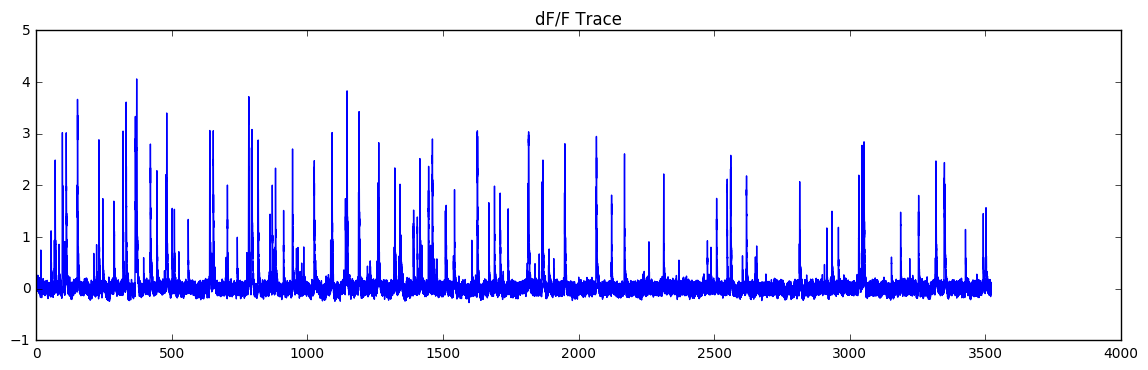

In [65]:
from matplotlib import pyplot as plt
%matplotlib inline

# plot
plt.figure(figsize=(14,4))
plt.title("Raw Trace")
plt.plot(time, raw_traces[0])
plt.show()

plt.figure(figsize=(14,4))
plt.title("Neuropil-corrected Fluorescence Trace")
plt.plot(time, corrected_traces[0])
plt.show()

plt.figure(figsize=(14,4))
plt.title("dF/F Trace")
plt.plot(time, dff[0,:])
plt.show()

In [63]:
len(corrected_traces[0])

105950